In [59]:
import os
import pickle
from glob import glob

import numpy as np
import more_itertools as mit
import scipy.stats as stats


import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


In [60]:
output_dir = "../local_images/cliff_world_archetype_equivalence"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [71]:
# Get a list of the pickle files in the `local_images` directory
pickle_files = sorted(glob("../local_images/cliff_world_param_viz/*.pkl"))
filename = pickle_files[-1]

# Load in the pickled data from the `local_images` directory
print(f"Loading {filename}")
with open(filename, "rb") as f:
    data = pickle.load(f)

# Data looks like this:
# pickle_data = {
#     "strategy_data": heatmap_info,
#     "grid_dimensions": (rows, cols),
#     "search_parameters": search_parameters,
#     "default_params": default_params,
#     "probs": probs,
#     "gammas": gammas,
# }

# Unpack the data
strategy_data = data["strategy_data"]
rows, cols = data["grid_dimensions"]
search_parameters = data["search_parameters"]
default_params = data["default_params"]
probs = data["probs"]
gammas = data["gammas"]

Loading ../local_images/cliff_world_param_viz/cliff_param_search_2023-04-24_13-52-32.pkl


In [72]:
def get_modes(strategies, prob_boundaries, gamma_boundaries):
    res = np.zeros((3, 3), dtype=int)
    # Iterate over pairs `(a1, a2), (a2, a3), ..., (a_{n-1}, a_n)` using more_itertools
    for i, (prob1, prob2) in enumerate(mit.windowed([0, *prob_boundaries, 1], 2)):
        for j, (g1, g2) in enumerate(mit.windowed([0, *gamma_boundaries, 1], 2)):
            # Find the mode for each strategy
            res[i, j] = stats.mode(strategies[((prob1 <= probs) & (probs <= prob2)).reshape((-1, 1))@((g1 <= gammas) & (gammas <= g2)).reshape((1, -1))], keepdims=False)[0]
    return res

In [73]:
# Show the results as a heatmap
def plot_archetype_strategy(strategies, probs, gammas, ax):
    res = get_modes(strategies, probs, gammas)
    sns.heatmap(res, annot=True, fmt="d", cmap="Blues", cbar=False, square=True, ax=ax)

    # Set tick labels to be "Low", "Mid", "High"
    ax.set_xticks(np.arange(3) + 0.5, ["Low", "Mid", "High"])
    ax.set_yticks(np.arange(3) + 0.5, ["Low", "Mid", "High"], rotation=0)

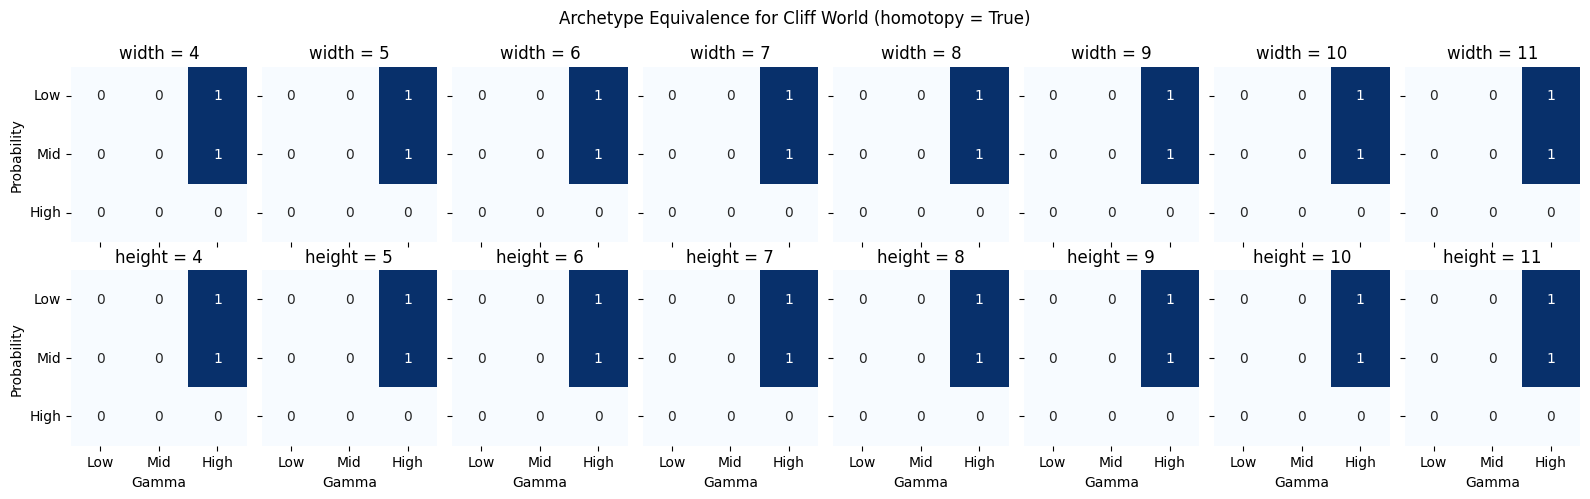

In [77]:
prob_boundaries = [0.5, 0.98]
gamma_boundaries = [0.5, 0.95]

use_homotopy = True

# Make a rows by cols grid of subplots
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(16, round(2.5 * rows)), sharex=True, sharey=True)
fig.subplots_adjust(top=0.9)

axs = axs.flatten()

# Iterate over the pickle files
for i, (strategies, s2idx, param, value) in enumerate(strategy_data):

    if use_homotopy:
        # Set all values >= 1 to 1 in strategies
        strategies[strategies >= 1] = 1


    # Plot the archetype strategy
    plot_archetype_strategy(strategies, prob_boundaries, gamma_boundaries, axs[i])

    # Set the title
    axs[i].set_title(f"{param} = {value}")

    # Set the x and y labels
    if i >= (rows - 1) * cols:
        axs[i].set_xlabel("Gamma")
    if i % cols == 0:
        axs[i].set_ylabel("Probability")

# Set the title
fig.suptitle(f"Archetype Equivalence for Cliff World (homotopy = {use_homotopy})")
plt.tight_layout()

now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Save the figure
plt.savefig(f"{output_dir}/archetype_equivalence_all_{now}.png", bbox_inches="tight")

plt.show();
